In [62]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [63]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [64]:
tf.enable_eager_execution()
print("Eager execution:",tf.executing_eagerly())

Eager execution: True


In [65]:
# Set up some global values here
content_path = r'C:\Users\harla\Desktop\Jupyter Notebooks\Neural Style Transfer\eric_main.jpg'
style_path = r'C:\Users\harla\Desktop\Jupyter Notebooks\Neural Style Transfer\style8.jpg'

In [66]:
## Click on the content picture and styling picture one after another! Do not click open till you have selected both the pictures.
# Use this when using google colab
#from google.colab import files
#uploaded = files.upload()

In [67]:
#for counter, fn in enumerate(uploaded.keys()):
# if counter == 0 :
#  content_path = fn
# else:
#  style_path = fn
  

In [68]:
print(content_path)
print(style_path)

C:\Users\harla\Desktop\Jupyter Notebooks\Neural Style Transfer\eric_main.jpg
C:\Users\harla\Desktop\Jupyter Notebooks\Neural Style Transfer\style8.jpg


In [69]:
def load_img(path_to_img):
  max_dim = 512
  img = kp_image.load_img(path_to_img)
  #print(type(img))
  long = max(img.size) 
  #print(long)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  #imshow(img)
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [70]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

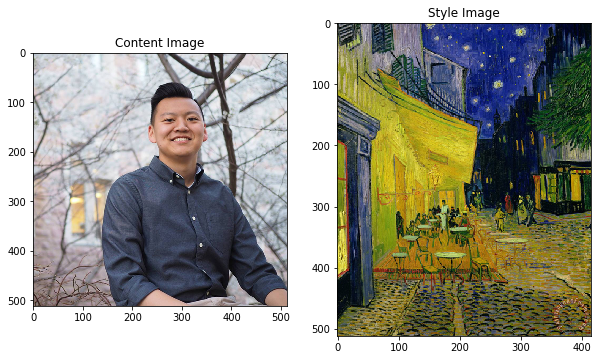

Content shape is: (1, 512, 512, 3)
Style shape is: (1, 512, 415, 3)


In [71]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

print('Content shape is:', content.shape)
print('Style shape is:', style.shape)

In [72]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [73]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

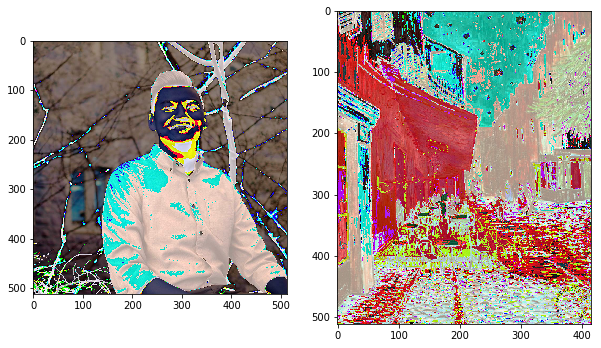

In [75]:
# Visualize how vgg preprocessing affects the image

content_processed = load_and_process_img(content_path)
plt.subplot(1, 2, 1)
imshow(content_processed)

style_processed = load_and_process_img(style_path)
plt.subplot(1, 2, 2)
imshow(style_processed)

In [76]:
# Content layer where will pull our feature maps
content_layers = ['block2_conv1'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [51]:
def get_model():
  """ Create a model with access to intermediate layers. 
  
  This function loads VGG19 model and accesses the intermediate layers. 
  These layers are used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  #  Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [16]:
 #vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
#alpha = vgg(content_processed)

In [17]:
#print(alpha.shape)

In [52]:
def get_content_loss(base_content, target):
    # base content : Output from content layer for input image 
    # target : Output from content layer for content image specified above
  return tf.reduce_mean(tf.square(base_content - target))

In [53]:
def gram_matrix(input_tensor):
  # Converting (1,n_H, n_W, n_C) tensor to (n_H * n_W, n_C) tensor
  channels = int(input_tensor.shape[-1])
  #print(channels)
  a = tf.reshape(input_tensor, [-1, channels])
  #print(a.shape)
  #n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram

In [54]:
#gram_content = gram_matrix(content_processed)
#print(gram_content.shape)

In [56]:
def get_style_loss(base_style, gram_target):
  """Expects output from one of the style layers for input image and gram matrix for the same style layer for style image"""

  # We can scale the loss at a given layer by the size of the feature map and the number of filters(suggested in original paper)
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [78]:
def get_feature_representations(model, content_path, style_path):
  """ We calculate content feature from content image and style features from syle image 

  This function will loads and preprocesses both the content and style 
  images from their path. It then feeds them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using - one we made in get_model()
    content_path: The path to the content image 
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features, to which the generated image content and style features 
    would be compared to and loss will be computed  
  """
  # Load content and style images 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from model  
  #style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    
  style_features = []
  for style_layer in style_outputs[:num_style_layers]:
    style_features.append(style_layer[0])
    
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [79]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  
  style_weight, content_weight = loss_weights
  
  # Style and content features of initial image
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_loss = 0
  content_loss = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
    
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_loss += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_loss += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_loss *= style_weight
  content_loss *= content_weight

  # Get total loss
  loss = style_loss + content_loss 
  return loss, style_loss, content_loss

In [80]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [81]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=500,
                       content_weight=1000, 
                       style_weight=0.1): 
  # No need to train any layers of the model. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    print('Iteration number:', i)
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

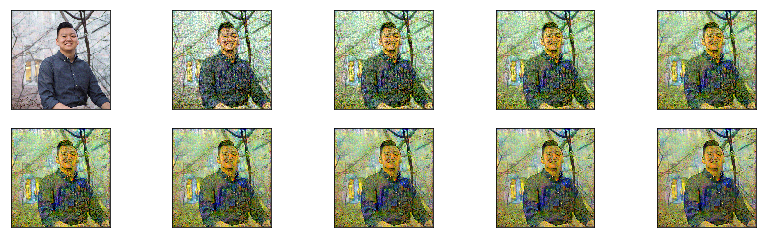

In [26]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=500)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

#  plt.subplot(1, 2, 1)
#  imshow(content, 'Content Image')

#  plt.subplot(1, 2, 2)
#  imshow(style, 'Style Image')

  if show_large_final: 
   out_put =  plt.figure(figsize=(10, 10))

   _ = plt.imshow(best_img)
  # _ = plt.title('Output Image')
   _ = plt.xticks([])
   _ = plt.yticks([])
   _ = plt.show()
   
    
   return out_put

<Figure size 720x360 with 0 Axes>

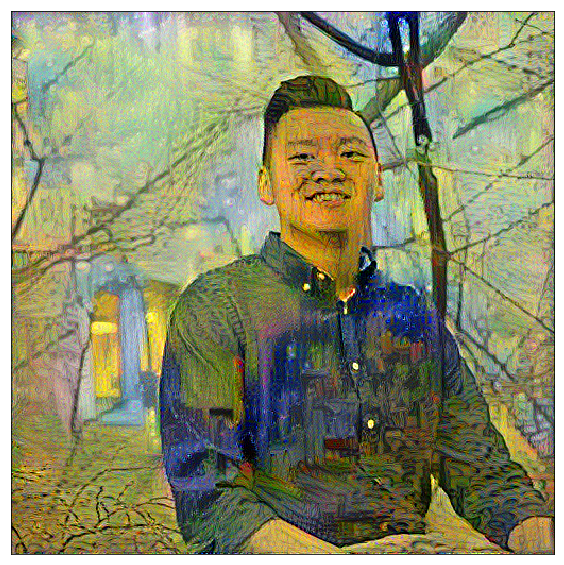

In [43]:
erc_pic = show_results(best, content_path, style_path)

In [0]:
#erc_pic.savefig('eric_ge.png')

In [0]:
#files.download( "eric_ge.png" )